Dataset: **Montreal Archive of Sleep Studies** (MASS) 
http://ceams-carsm.ca/mass/

In [1]:
# !pip install mne pyedflib seglearn tsfel tsfresh antropy

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.append("../../ML_tools/src/")

sys.path.append("../src/")

In [3]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

In [4]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from plotly_resampler import FigureResampler

## Download the data

In order to access the data you should submit a request as is described here; http://ceams-carsm.ca/mass/ 

# Create dataloader

## Some EDF loading funcs

In [5]:
from data import load_signals, load_annotations, annotation_to_30s_labels

## Load some data

In [6]:
data_folder = "../../../../data/sleep/MASSDB/"

os.listdir(data_folder)

['SS3_EDF_part2',
 'SS3_EDF_part1',
 'SS5_EDF.zip',
 'SS1_Annotations',
 'SS1_EDF_1_30.zip',
 'SS1_EDF_part2.zip',
 'SS5_Annotations',
 'SS4_Annotations',
 'SS2_Annotations',
 'SS3_Annotations',
 'SS2_EDF_part1.zip',
 'SS4_EDF_part1.zip']

In [7]:
os.listdir(data_folder + "SS3_EDF_part1")[:10]

['01-03-0021 PSG.edf',
 '01-03-0006 Base.edf',
 '01-03-0006 PSG.edf',
 '01-03-0025 Base.edf',
 '01-03-0009 PSG.edf',
 '01-03-0007 PSG.edf',
 '01-03-0024 PSG.edf',
 '01-03-0030 PSG.edf',
 '01-03-0032 Base.edf',
 '01-03-0024 Base.edf']

In [8]:
len(os.listdir(data_folder + "SS3_EDF_part1"))

70

In [9]:
!du -hs ../../../../data/sleep/MASSDB/SS3_EDF_part1

13G	../../../../data/sleep/MASSDB/SS3_EDF_part1


=> In total 70 files (35 PSG files - 35 hypnogram files) => 13 GB

In [10]:
os.listdir(data_folder + "SS3_EDF_part2")[:10]

['01-03-0047 Base.edf',
 '01-03-0062 PSG.edf',
 '01-03-0039 Base.edf',
 '01-03-0048 PSG.edf',
 '01-03-0036 Base.edf',
 '01-03-0053 Base.edf',
 '01-03-0037 Base.edf',
 '01-03-0053 PSG.edf',
 '01-03-0061 Base.edf',
 '01-03-0064 PSG.edf']

In [11]:
len(os.listdir(data_folder + "SS3_EDF_part2"))

54

In [12]:
!du -hs ../../../../data/sleep/MASSDB/SS3_EDF_part2

12G	../../../../data/sleep/MASSDB/SS3_EDF_part2


=> In total 54 files (27 PSG files - 27 hypnogram files) => 12 GB

In [13]:
dfs = []
sub_folders = ["SS3_EDF_part1", "SS3_EDF_part2"]
for sub_folder in sub_folders:
    sorted_files = sorted(os.listdir(data_folder + sub_folder))
    psg_hypnogram_files = [(h, p) for p, h in zip(sorted_files[::2], sorted_files[1:][::2])]
    df_files = pd.DataFrame(psg_hypnogram_files, columns=["psg_file", "label_file"])
    df_files["subfolder"] = sub_folder
    dfs += [df_files]
    
df_files = pd.concat(dfs)
    
# Because for the SC study patients were monitored for 2 consecutive nights
df_files["patient_id"] = df_files.psg_file.apply(lambda f: f.split(" ")[0])
df_files

,psg_file,label_file,subfolder,patient_id
0,01-03-0001 PSG.edf,01-03-0001 Base.edf,SS3_EDF_part1,01-03-0001
1,01-03-0002 PSG.edf,01-03-0002 Base.edf,SS3_EDF_part1,01-03-0002
2,01-03-0003 PSG.edf,01-03-0003 Base.edf,SS3_EDF_part1,01-03-0003
3,01-03-0004 PSG.edf,01-03-0004 Base.edf,SS3_EDF_part1,01-03-0004
4,01-03-0005 PSG.edf,01-03-0005 Base.edf,SS3_EDF_part1,01-03-0005
...,...,...,...,...
22,01-03-0060 PSG.edf,01-03-0060 Base.edf,SS3_EDF_part2,01-03-0060
23,01-03-0061 PSG.edf,01-03-0061 Base.edf,SS3_EDF_part2,01-03-0061
24,01-03-0062 PSG.edf,01-03-0062 Base.edf,SS3_EDF_part2,01-03-0062
25,01-03-0063 PSG.edf,01-03-0063 Base.edf,SS3_EDF_part2,01-03-0063


In [14]:
df_files.psg_file.nunique()

62

In [15]:
df_files.patient_id.nunique()

62

=> psg file can be used as recordingid   
=> patient id can be used as patient id 

In [16]:
signal_dict = {}

for idx in range(len(df_files)):
    sig, freq = load_signals(data_folder + df_files.iloc[idx].subfolder + "/" + df_files.iloc[idx].psg_file, only_info=True)
    for s, f in zip(sig, freq):
        if (s,f) in signal_dict.keys():
            signal_dict[(s,f)].append(idx)
        else:
            signal_dict[(s,f)] = [idx]
            
[(k, len(v)) for k, v in signal_dict.items()]

[(('EOG Left Horiz', 256), 62),
 (('EOG Right Horiz', 256), 62),
 (('EEG Fp1-LER', 256), 62),
 (('EEG Fp2-LER', 256), 62),
 (('EEG F7-LER', 256), 62),
 (('EEG F8-LER', 256), 62),
 (('EEG F3-LER', 256), 62),
 (('EEG F4-LER', 256), 62),
 (('EEG T3-LER', 256), 62),
 (('EEG T4-LER', 256), 62),
 (('EEG C3-LER', 256), 62),
 (('EEG C4-LER', 256), 62),
 (('EEG T5-LER', 256), 62),
 (('EEG T6-LER', 256), 62),
 (('EEG P3-LER', 256), 62),
 (('EEG P4-LER', 256), 62),
 (('EEG O1-LER', 256), 62),
 (('EEG O2-LER', 256), 62),
 (('EEG Fz-LER', 256), 62),
 (('EEG Cz-LER', 256), 62),
 (('EEG Pz-LER', 256), 62),
 (('EEG Oz-LER', 256), 62),
 (('EEG A2-LER', 256), 43),
 (('EMG Chin1', 128), 43),
 (('EMG Chin2', 128), 43),
 (('EMG Chin3', 128), 43),
 (('ECG ECGI', 256), 43),
 (('EMG Chin1', 256), 19),
 (('EMG Chin2', 256), 19),
 (('EMG Chin3', 256), 19),
 (('ECG ECGI', 512), 19),
 (('Resp Belt Thor', 64), 19),
 (('Resp Belt Abdo', 64), 19)]

In [17]:
common_signals = [
    'EOG Left Horiz', 'EOG Right Horiz',  # All have the same sampling rate (100 Hz)
    'EEG C4-LER', 'EEG O1-LER', 'EEG F4-LER', 'EEG F8-LER', 'EEG Cz-LER', #'EEG P4-LER',
    # 'EEG Cz-LER', 'EEG Pz-LER', 'EEG Oz-LER',
    'EMG Chin1', 'EMG Chin2', #'EMG Chin3',  # Different sampling rate: 100 Hz for telemetry & 1 Hz for cassette
]

In [18]:
data = load_signals(data_folder + df_files.iloc[0].subfolder + "/" + df_files.iloc[0].psg_file, retrieve_signals=common_signals)
annotations = load_annotations(
    data_folder + df_files.iloc[0].subfolder + "/" + df_files.iloc[0].label_file,
    data_folder + df_files.iloc[0].subfolder + "/" + df_files.iloc[0].psg_file
)

In [19]:
# Used for plotting
cats = [
    "Sleep stage ?",
    "Movement time",
    "Sleep stage W",
    "Sleep stage 1",
    "Sleep stage 2",
    "Sleep stage 3",
    "Sleep stage 4",
    "Sleep stage R",
][::-1]


# EDA + pipeline (for 1 patient)

In [20]:
idxs = ["EOG", "EEG", "EMG"]

fig = FigureResampler(
    make_subplots(
        rows=len(idxs) + 1,
        cols=1,
        shared_xaxes=True,
        subplot_titles=idxs + ["Hypnogram"],
        vertical_spacing=0.05,
    ),
    default_n_shown_samples=2_000,
)


for s in data:
    try:
        idx = idxs.index(s.name.split(" ")[0]) + 1
    except:
        continue
    fig.add_trace(
        go.Scattergl(
            x=[], y=[], name=s.name, line_width=1,
        ),
        hf_x=s.index,
        hf_y=s.values,
        row=idx,
        col=1,
    )

fig.add_trace(
    go.Scattergl(
        x=[], y=[], name="Hypnogram", line_width=1.5, line_shape="hv",
    ),
    hf_x=annotation_to_30s_labels(annotations).index,
    hf_y=annotation_to_30s_labels(annotations)["label"].values,
    row=len(idxs) + 1,
    col=1,
)

fig.update_layout(height=900)
fig.update_yaxes(categoryorder="array", categoryarray=cats)

fig.update_layout(
    legend_traceorder="normal",
    template="plotly_white",
    #     legend=dict(orientation="h", y=1.07, xanchor="right", x=1),
)

fig.show_dash(port=8042)

Dash app running on http://127.0.0.1:8042/


## Process the signals

In [21]:
## Processing
from scipy.signal import butter, lfilter, iirnotch

from tsflex.processing import SeriesPipeline, SeriesProcessor

def determine_fs(sig):
    return int(10**9 / data[0].index.to_series().diff().median().to_timedelta64().astype(float))

def butter_bandpass_filter(sig, lowcut, highcut, fs=None, order=5):
    if fs is None:
        fs = determine_fs(sig)
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype="band")
    y = lfilter(b, a, sig)
    return y

def resample(sig, fs):
    return sig.resample(pd.Timedelta(10**3/fs, unit="ms")).mean().interpolate()

def create_montage(sig1, sig2):
    return (sig1 - sig2).rename(sig1.name + " - " + sig2.name)

def average(sig1, sig2):
    return (sig1 + sig2).rename(sig1.name + "_" + sig2.name + "_[AVG]") / 2

eeg_signals = [s for s in common_signals if s.startswith("EEG")]
eog_signals = [s for s in common_signals if s.startswith("EOG")]
emg_signals = [s for s in common_signals if s.startswith("EMG")]

eeg_bandpass = SeriesProcessor(
    function=butter_bandpass_filter,
    series_names=eeg_signals + eog_signals,
    lowcut=0.4,
    highcut=30,
    fs=256,
)

emg_bandpass = SeriesProcessor(
    function=butter_bandpass_filter,
    series_names=emg_signals,
    lowcut=0.5,
    highcut=10,
)

## OG pipeline
process_pipe = SeriesPipeline(
    [
        eeg_bandpass,
        emg_bandpass,
        SeriesProcessor(resample, series_names=common_signals, fs=100),
        SeriesProcessor(
            create_montage, 
            series_names=[("EEG C4-LER", "EEG O1-LER"), ("EEG F4-LER", "EOG Left Horiz")],#, ("EEG F8-LER", "EEG Cz-LER")]
        ),
        SeriesProcessor(
            average,
            series_names=[("EOG Left Horiz", "EOG Right Horiz"), ("EMG Chin1", "EMG Chin2")]
        ),
        # emg_bandpass,
    ]
)

out_signals = ['EEG C4-LER - EEG O1-LER',
#  'EEG F8-LER - EEG Cz-LER',
 'EEG F4-LER - EOG Left Horiz',
 'EOG Left Horiz_EOG Right Horiz_[AVG]',
 'EMG Chin1_EMG Chin2_[AVG]']

process_pipe = SeriesPipeline(
    [        
        eeg_bandpass,
        emg_bandpass,
        SeriesProcessor(
            average,
            series_names=[("EOG Left Horiz", "EOG Right Horiz"), ("EMG Chin1", "EMG Chin2")]
        ),
        SeriesProcessor(
            create_montage, 
            series_names=[("EEG C4-LER", "EEG O1-LER"), ("EEG F4-LER", "EOG Left Horiz")]#, ("EEG F8-LER", "EEG Cz-LER")]
        ),
        SeriesProcessor(resample, series_names=out_signals, fs=100),
    ]
)

process_pipe

[
	butter_bandpass_filter {'lowcut': 0.4, 'highcut': 30, 'fs': 256} :  ('EEG C4-LER',) ('EEG O1-LER',) ('EEG F4-LER',) ('EEG F8-LER',) ('EEG Cz-LER',) ('EOG Left Horiz',) ('EOG Right Horiz',)
	butter_bandpass_filter {'lowcut': 0.5, 'highcut': 10} :  ('EMG Chin1',) ('EMG Chin2',)
	average {} :  ('EOG Left Horiz', 'EOG Right Horiz') ('EMG Chin1', 'EMG Chin2')
	create_montage {} :  ('EEG C4-LER', 'EEG O1-LER') ('EEG F4-LER', 'EOG Left Horiz')
	resample {'fs': 100} :  ('EEG C4-LER - EEG O1-LER',) ('EEG F4-LER - EOG Left Horiz',) ('EOG Left Horiz_EOG Right Horiz_[AVG]',) ('EMG Chin1_EMG Chin2_[AVG]',)
]

In [22]:
%%time
data_processed = process_pipe.process(data, return_all_series=False, drop_keys=eeg_signals + eog_signals + emg_signals)
# data_processed = process_pipe.process(data, return_all_series=False)#, drop_keys=eeg_signals + eog_signals + emg_signals)

CPU times: user 2.11 s, sys: 694 ms, total: 2.8 s
Wall time: 2.77 s


In [23]:
for s in data_processed:
    idx = idxs.index(s.name.split(" ")[0]) + 1
    fig.add_trace(
        go.Scatter(x=[], y=[], name=s.name + " processed", line_width=1),
        hf_x=s.index,
        hf_y=s.values,
        row=idx,
        col=1,
    )
    
fig.show_dash(port=8042)

Dash app running on http://127.0.0.1:8042/


## Extract the features

In [24]:
eeg_cols = [s.name for s in data_processed if s.name.startswith("EEG")]
eog_cols = [s.name for s in data_processed if s.name.startswith("EOG")]
emg_cols = [s.name for s in data_processed if s.name.startswith("EMG")]
print(eeg_cols)
print(eog_cols)
print(emg_cols)

['EEG C4-LER - EEG O1-LER', 'EEG F4-LER - EOG Left Horiz']
['EOG Left Horiz_EOG Right Horiz_[AVG]']
['EMG Chin1_EMG Chin2_[AVG]']


In [25]:
# Create the collection of tsfresh features to extract

tsfresh_settings = {
    "fft_aggregated": [
        {"aggtype": "centroid"},
        {"aggtype": "variance"},
        {"aggtype": "skew"},
        {"aggtype": "kurtosis"},
    ],
    "fourier_entropy": [
        {"bins": 2},
        {"bins": 3},
        {"bins": 5},
        {"bins": 10},
        {"bins": 30},
        {"bins": 60},
        {"bins": 100},
    ],
    "binned_entropy": [
        {"max_bins": 5},
        {"max_bins": 10},
        {"max_bins": 30},
        {"max_bins": 60},
    ],
}

tsfresh_settings

{'fft_aggregated': [{'aggtype': 'centroid'},
  {'aggtype': 'variance'},
  {'aggtype': 'skew'},
  {'aggtype': 'kurtosis'}],
 'fourier_entropy': [{'bins': 2},
  {'bins': 3},
  {'bins': 5},
  {'bins': 10},
  {'bins': 30},
  {'bins': 60},
  {'bins': 100}],
 'binned_entropy': [{'max_bins': 5},
  {'max_bins': 10},
  {'max_bins': 30},
  {'max_bins': 60}]}

In [26]:
import antropy as ant
import scipy.stats as ss
from yasa import bandpower

import scipy.stats as ss
from tsflex.features import (
    FeatureCollection,
    FuncWrapper,
    MultipleFeatureDescriptors,
    FuncWrapper,
)
from tsflex.features.integrations import tsfresh_settings_wrapper


def wrapped_higuchi_fd(x):
    x = np.array(x, dtype="float64")
    return ant.higuchi_fd(x)


bands = [
    (0.4, 1, "sdelta"),
    (1, 4, "fdelta"),
    (4, 8, "theta"),
    (8, 12, "alpha"),
    (12, 16, "sigma"),
    (16, 30, "beta"),
]
bandpowers_ouputs = [b[2] for b in bands] + ["TotalAbsPow"]


def wrapped_bandpowers(x, sf, bands):
    return bandpower(x, sf=sf, bands=bands).values[0][:-2]


time_funcs = [
    np.std,
    ss.iqr,
    ss.skew,
    ss.kurtosis,
    ant.num_zerocross,
    FuncWrapper(
        ant.hjorth_params, output_names=["horth_mobility", "hjorth_complexity"]
    ),
    wrapped_higuchi_fd,
    ant.petrosian_fd,
    ant.perm_entropy,
] + tsfresh_settings_wrapper(tsfresh_settings)

freq_funcs = [
    FuncWrapper(wrapped_bandpowers, sf=100, bands=bands, output_names=bandpowers_ouputs)
]

time_feats = MultipleFeatureDescriptors(
    time_funcs, eeg_cols + eog_cols + emg_cols,
    windows=["30s", "60s", "120s"], strides="30s",
)
freq_feats = MultipleFeatureDescriptors(
    freq_funcs, eeg_cols + eog_cols,
    windows=["30s", "60s", "120s"], strides="30s",
)

feature_collection = FeatureCollection([time_feats, freq_feats])
# fc

In [27]:
import logging 

from tsflex.features.logger import logger
logger.setLevel(level=logging.ERROR)

from tsflex.processing.logger import logger
logger.setLevel(level=logging.ERROR)

In [28]:
# %%time
feats = feature_collection.calculate(data_processed, return_df=True, show_progress=True)
feats

  0%|          | 0/261 [00:00<?, ?it/s]

,EEG C4-LER - EEG O1-LER__TotalAbsPow__w=1m_s=30s,EEG C4-LER - EEG O1-LER__TotalAbsPow__w=2m_s=30s,EEG C4-LER - EEG O1-LER__TotalAbsPow__w=30s_s=30s,EEG C4-LER - EEG O1-LER__alpha__w=1m_s=30s,EEG C4-LER - EEG O1-LER__alpha__w=2m_s=30s,EEG C4-LER - EEG O1-LER__alpha__w=30s_s=30s,EEG C4-LER - EEG O1-LER__beta__w=1m_s=30s,EEG C4-LER - EEG O1-LER__beta__w=2m_s=30s,EEG C4-LER - EEG O1-LER__beta__w=30s_s=30s,EEG C4-LER - EEG O1-LER__binned_entropy_{'max_bins': 10}__w=1m_s=30s,...,EOG Left Horiz_EOG Right Horiz_[AVG]__skew__w=30s_s=30s,EOG Left Horiz_EOG Right Horiz_[AVG]__std__w=1m_s=30s,EOG Left Horiz_EOG Right Horiz_[AVG]__std__w=2m_s=30s,EOG Left Horiz_EOG Right Horiz_[AVG]__std__w=30s_s=30s,EOG Left Horiz_EOG Right Horiz_[AVG]__theta__w=1m_s=30s,EOG Left Horiz_EOG Right Horiz_[AVG]__theta__w=2m_s=30s,EOG Left Horiz_EOG Right Horiz_[AVG]__theta__w=30s_s=30s,EOG Left Horiz_EOG Right Horiz_[AVG]__wrapped_higuchi_fd__w=1m_s=30s,EOG Left Horiz_EOG Right Horiz_[AVG]__wrapped_higuchi_fd__w=2m_s=30s,EOG Left Horiz_EOG Right Horiz_[AVG]__wrapped_higuchi_fd__w=30s_s=30s
2000-01-01 21:28:23,NaN,NaN,42.457673,NaN,NaN,0.147711,NaN,NaN,0.060797,NaN,...,-1.300548,NaN,NaN,9.632114,NaN,NaN,0.089987,NaN,NaN,1.622883
2000-01-01 21:28:53,38.621956,NaN,38.987855,0.109785,NaN,0.074727,0.05605,NaN,0.04344,1.053097,...,-0.236141,12.814378,NaN,15.328005,0.073491,NaN,0.045014,1.537349,NaN,1.450732
2000-01-01 21:29:23,32.425519,NaN,44.962163,0.18713,NaN,0.458264,0.057253,NaN,0.05073,1.067667,...,0.119529,15.891333,NaN,16.412610,0.051673,NaN,0.067629,1.457032,NaN,1.467876
2000-01-01 21:29:53,32.836996,32.849248,27.899303,0.316914,0.193288,0.221476,0.065687,0.06356,0.072345,1.754409,...,-0.123054,11.906914,12.370917,3.754816,0.075971,0.076665,0.090717,1.553211,1.543092,1.676340
2000-01-01 21:30:23,23.646118,26.412114,18.956875,0.17418,0.186158,0.147383,0.06996,0.067219,0.072987,1.744690,...,0.440301,5.362053,11.859761,6.588197,0.107171,0.084564,0.102644,1.605256,1.516918,1.532670
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2000-01-02 05:59:53,65.833353,70.243874,55.544329,0.080932,0.075526,0.088443,0.019928,0.018361,0.029542,1.677782,...,-0.057074,6.074860,9.900778,6.215825,0.152136,0.158501,0.187128,1.433275,1.375046,1.476446
2000-01-02 06:00:23,83.661787,77.551164,151.995921,0.089835,0.074343,0.084587,0.028249,0.020438,0.061087,0.570209,...,0.278932,75.587059,53.677543,106.715272,0.134824,0.13933,0.032963,1.259598,1.279615,1.234685
2000-01-02 06:00:53,92.1134,70.633087,63.986004,0.11289,0.104528,0.135875,0.099761,0.031928,0.147312,0.605516,...,0.861418,82.853550,58.743598,48.386638,0.057948,0.103341,0.068542,1.284611,1.302830,1.376458
2000-01-02 06:01:23,94.892555,86.140444,285.597411,0.072359,0.090676,0.020969,0.146382,0.062991,0.07232,0.831515,...,0.614399,63.199168,69.669048,75.146153,0.092577,0.051783,0.083237,1.331246,1.299245,1.304121


# Pipeline for all patients

In [29]:
from tqdm.auto import tqdm

def slice_data(series_list, start):
    return [s[s.index >= start] for s in series_list]

df_feats = []
for sub_folder, psg_file, hypnogram_file in tqdm(zip(df_files.subfolder, df_files.psg_file, df_files.label_file)):
    file_folder = data_folder + sub_folder + "/"
    # Load the annotations
    annotations = load_annotations(file_folder + hypnogram_file, file_folder + psg_file)
    annotations = annotation_to_30s_labels(annotations)
    start_idx = annotations.index.values[0]
    # Load the data, process the data and extract features
    data = load_signals(file_folder + psg_file, retrieve_signals=common_signals)
    data_processed = process_pipe.process(data, drop_keys=eeg_signals + eog_signals + emg_signals)
    df_feat = feature_collection.calculate(
        slice_data(data_processed, start_idx), return_df=True, window_idx="begin"
    ).astype("float32")
    # Add the labels (and reduce features to only data for which we have labels)
    df_feat = pd.merge_asof(df_feat, annotations, left_index=True, right_index=True, tolerance=pd.Timedelta(0.05, unit="s"), direction="nearest")
    # Add the file name & folder
    df_feat["psg_file"] = psg_file
    df_feat["patient_id"] = psg_file.split(" ")[0]
    # Collect the dataframes
    df_feats += [df_feat]

df_feats = pd.concat(df_feats)
df_feats.rename(columns={"description": "label"}, inplace=True)

0it [00:00, ?it/s]

In [30]:
df_feats.to_parquet("../features/mass_SS3_features_ALL_.parquet")

## Load data

In [56]:
df_feats = pd.read_parquet("../features/mass_SS3_features_ALL_.parquet")
df_feats.shape

(62767, 366)

In [57]:
df_feats["label"].value_counts()

Sleep stage 2    29802
Sleep stage R    10581
Sleep stage 3     7653
Sleep stage W     6442
Sleep stage 1     4839
Sleep stage ?     3448
Name: label, dtype: int64

In [58]:
df_feats[~df_feats.psg_file.isin(df_files.psg_file.unique())].psg_file.nunique()

0

In [59]:
df_feats.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 62767 entries, 2000-01-01 21:28:00.010000 to 2000-01-02 07:14:30.010000
Columns: 366 entries, EEG C4-LER - EEG O1-LER__TotalAbsPow__w=1m_s=30s to patient_id
dtypes: float32(363), object(3)
memory usage: 88.8+ MB


In [60]:
bands = ["alpha", "beta", "sdelta", "fdelta", "sigma", "theta"]
for eeg_sig in eeg_cols:
    eeg_bands = [c for c in df_feats.columns if c.startswith(eeg_sig) and c.split("__")[1] in bands]
    windows = sorted(set(b.split("__")[-1] for b in eeg_bands))
    for window in windows:
        # Select the spectral powers
        delta = df_feats["__".join([eeg_sig, "sdelta", window])] + df_feats["__".join([eeg_sig, "fdelta", window])]
        fdelta_theta = df_feats["__".join([eeg_sig, "fdelta", window])] + df_feats["__".join([eeg_sig, "theta", window])]
        alpha = df_feats["__".join([eeg_sig, "alpha", window])]
        beta = df_feats["__".join([eeg_sig, "beta", window])]
        theta = df_feats["__".join([eeg_sig, "theta", window])]
        sigma = df_feats["__".join([eeg_sig, "sigma", window])]
        # Calculate the ratios
        df_feats["__".join([eeg_sig, "fdelta+theta", window])] = fdelta_theta.astype("float32")        

        df_feats["__".join([eeg_sig, "alpha/theta", window])] = (alpha / theta).astype("float32")
        df_feats["__".join([eeg_sig, "delta/beta", window])] = (delta / beta).astype("float32")
        df_feats["__".join([eeg_sig, "delta/sigma", window])] = (delta / sigma).astype("float32")
        df_feats["__".join([eeg_sig, "delta/theta", window])] = (delta / theta).astype("float32")
df_feats.shape

(62767, 396)

In [61]:
skip_cols = ["psg_file", "label", "patient_id"]
feat_cols = [c for c in df_feats.columns if c not in skip_cols]

In [62]:
# Add the 30s features from the minute before and the minute after the epoch (= current sample of 30s) to the epoch
feats_30s = [f for f in df_feats.columns if "w=30s" in f]
# feats_1m = [f for f in df_feats.columns if "w=1m" in f]
# feats_2m = [f for f in df_feats.columns if "w=2m" in f]
dfs = []
for psg_file in df_feats.psg_file.unique():
    sub_df = df_feats[df_feats.psg_file == psg_file]
    # sub_df = sub_df.merge(sub_df[feats_2m].shift(8).add_suffix("_shift=4m"), left_index=True, right_index=True)
    # sub_df = sub_df.merge(sub_df[feats_1m].shift(4).add_suffix("_shift=2m"), left_index=True, right_index=True)
    sub_df = sub_df.merge(sub_df[feats_30s].shift(2).add_suffix("_shift=1m"), left_index=True, right_index=True)
    sub_df = sub_df.merge(sub_df[feats_30s].shift(1).add_suffix("_shift=30s"), left_index=True, right_index=True)
    sub_df = sub_df.merge(sub_df[feats_30s].shift(-1).add_suffix("_shift=-30s"), left_index=True, right_index=True)
    sub_df = sub_df.merge(sub_df[feats_30s].shift(-2).add_suffix("_shift=-1m"), left_index=True, right_index=True)
    # sub_df = sub_df.merge(sub_df[feats_1m].shift(-4).add_suffix("_shift=-2m"), left_index=True, right_index=True)
    # sub_df = sub_df.merge(sub_df[feats_2m].shift(-8).add_suffix("_shift=-4m"), left_index=True, right_index=True)
    dfs += [sub_df]
df_feats = pd.concat(dfs)
df_feats.shape

(62767, 920)

In [63]:
df_feats.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 62767 entries, 2000-01-01 21:28:00.010000 to 2000-01-02 07:14:30.010000
Columns: 920 entries, EEG C4-LER - EEG O1-LER__TotalAbsPow__w=1m_s=30s to EEG F4-LER - EOG Left Horiz__delta/theta__w=30s_s=30s_shift=-1m
dtypes: float32(917), object(3)
memory usage: 221.5+ MB


In [64]:
# Postprocess labels
df_feats.loc[df_feats["label"] == "Sleep stage 4", "label"] = "Sleep stage 3"
df_feats.loc[df_feats["label"] == "Movement time", "label"] = "Sleep stage W"
df_feats = df_feats[df_feats["label"] != "Sleep stage ?"]  # Label that is given when recording is done / end of the night

df_feats = df_feats[~df_feats["label"].isna()]

In [65]:
df_feats.shape

(59317, 920)

## EDA on labels

<AxesSubplot:>

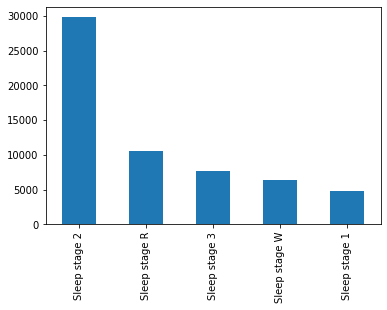

In [66]:
df_feats["label"].value_counts().plot(kind="bar")

In [67]:
df_feats["label"].value_counts()

Sleep stage 2    29802
Sleep stage R    10581
Sleep stage 3     7653
Sleep stage W     6442
Sleep stage 1     4839
Name: label, dtype: int64

=> There is quite some label imbalance

## EDA on features

In [68]:
skip_cols = ["psg_file", "label", "patient_id"]
feat_cols = [c for c in df_feats.columns if c not in skip_cols]

In [69]:
import math

import matplotlib.pyplot as plt

plot_cols = [c for c in feat_cols if not "_shift=" in c]

# n_cols = 10
# n_rows = math.ceil(len(plot_cols) / n_cols)
# plt.figure(figsize=(n_cols * 4.5, n_rows * 4.5))

# for idx, col in enumerate(plot_cols):
#     plt.subplot(n_rows, n_cols, idx + 1)
#     plt.boxplot(df_feats[col].dropna(), vert=True)
#     plt.xlabel(col)

# plt.tight_layout()
# plt.show()

# ML

In [70]:
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    classification_report,
    f1_score,
    cohen_kappa_score,
    log_loss,
)
from sklearn.model_selection import GroupKFold, StratifiedGroupKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import QuantileTransformer

from sklearn.linear_model import SGDClassifier
from sklearn.feature_selection import SelectFpr, chi2

In [71]:
from ml_tools.visualizations.models_linear import plot_linear_classification_coefs
from ml_tools.visualizations.models import plot_learning_curve
from ml_tools.visualizations.evaluation import plot_confusion_matrix

## The simple, linear pipeline

In [72]:
### Create pipeline
pipe = Pipeline(
    [
        ("impute", SimpleImputer()),
        ("scale", QuantileTransformer()),
        ("selector", SelectFpr(chi2, alpha=1e-5)),
        (
            "linear_model",
            SGDClassifier(
                loss="log",
                average=True,
                class_weight="balanced",
                n_jobs=5,
                random_state=0,
            ),
        ),
    ]
)

### Grouped 10-fold results for all the data

In [73]:
# Total of 10 folds
gkfold = StratifiedGroupKFold(n_splits=10)
cv = gkfold.split(df_feats, df_feats["label"], groups=df_feats.psg_file)

res = cross_validate(
    pipe,
    df_feats[feat_cols],
    df_feats["label"],
    scoring=["f1_macro", "balanced_accuracy", "accuracy", "neg_log_loss"],
    cv=cv,
    n_jobs=30,
    return_train_score=True,
    return_estimator=True,
)

In [74]:
print("20-FOLD: TRAIN")
print("  MACRO F1:          ", round(np.mean(res["train_f1_macro"]), 4))
print("  Balanced accuracy: ", round(np.mean(res["train_balanced_accuracy"]), 4))
print("  Accuracy:          ", round(np.mean(res["train_accuracy"]), 4))
print("  Log loss:          ", round(np.mean(-1 * res["train_neg_log_loss"]), 4))

20-FOLD: TRAIN
  MACRO F1:           0.828
  Balanced accuracy:  0.8376
  Accuracy:           0.87
  Log loss:           0.5347


In [75]:
print("20-FOLD: TEST")
print("  MACRO F1:          ", round(np.mean(res["test_f1_macro"]), 4))
print("  Balanced accuracy: ", round(np.mean(res["test_balanced_accuracy"]), 4))
print("  Accuracy:          ", round(np.mean(res["test_accuracy"]), 4))
print("  Log loss:          ", round(np.mean(-1 * res["test_neg_log_loss"]), 4))


20-FOLD: TEST
  MACRO F1:           0.8023
  Balanced accuracy:  0.8125
  Accuracy:           0.851
  Log loss:           0.6721


In [76]:
preds = []
preds_proba = []
y_trues = []
selected_feats = []
cv = gkfold.split(df_feats, df_feats["label"], groups=df_feats.patient_id)
for fold_ix, (train_idx, test_idx) in enumerate(cv):
    X_train = df_feats[feat_cols].iloc[train_idx]
    y_train = df_feats["label"].iloc[train_idx]
    X_test = df_feats[feat_cols].iloc[test_idx]
    y_test = df_feats["label"].iloc[test_idx]
    
    estimator = res["estimator"][fold_ix]
    preds += [estimator.predict(X_test)]
    preds_proba += [estimator.predict_proba(X_test)]
    y_trues += [y_test]
    selected_feats += [np.array(feat_cols)[estimator["selector"].get_support()]]

preds = np.hstack(preds)
y_trues = np.hstack(y_trues)
preds_proba = np.vstack(preds_proba)

917 features in total
fold 0  906 features selected
fold 1  911 features selected
fold 2  905 features selected
fold 3  905 features selected
fold 4  909 features selected
fold 5  905 features selected
fold 6  907 features selected
fold 7  909 features selected
fold 8  909 features selected
fold 9  905 features selected

899 features in intersection
913 features in union


Text(0.5, 0, 'times selected')

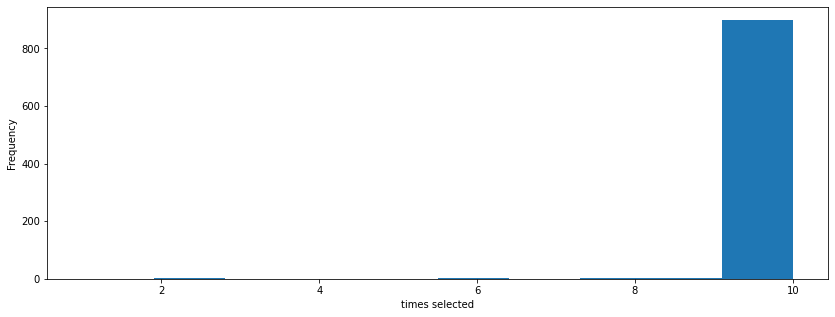

In [77]:
print(f"{len(feat_cols)} features in total")

selection_df = pd.DataFrame(data=set.union(*map(set, selected_feats)), columns=["feature"])
selection_df["times_selected"] = 0

for fold, feats in enumerate(selected_feats):
    print(f"fold {fold}  {len(feats)} features selected")
    selection_df.loc[selection_df.feature.isin(feats), "times_selected"] += 1

print()
print(f"{len(set.intersection(*map(set, selected_feats)))} features in intersection")
print(f"{len(set.union(*map(set, selected_feats)))} features in union")

ax = selection_df["times_selected"].plot(kind="hist", bins=10, figsize=(14,5))
plt.xlabel("times selected")

In [78]:
print("F1:", f1_score(preds, y_trues, average="macro"))
print("ACC:", accuracy_score(preds, y_trues))
print("KAPPA:", cohen_kappa_score(preds, y_trues))
print("LOG LOSS:", log_loss(y_trues, preds_proba))

F1: 0.8043379197986413
ACC: 0.8511893723553113
KAPPA: 0.7837254193055819
LOG LOSS: 0.6727877159636771


In [79]:
print(classification_report(preds, y_trues))

               precision    recall  f1-score   support

Sleep stage 1       0.55      0.55      0.55      4782
Sleep stage 2       0.88      0.91      0.89     28599
Sleep stage 3       0.89      0.80      0.84      8500
Sleep stage R       0.88      0.86      0.87     10807
Sleep stage W       0.89      0.86      0.87      6629

     accuracy                           0.85     59317
    macro avg       0.81      0.80      0.80     59317
 weighted avg       0.85      0.85      0.85     59317



<AxesSubplot:title={'center':'Normalized confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

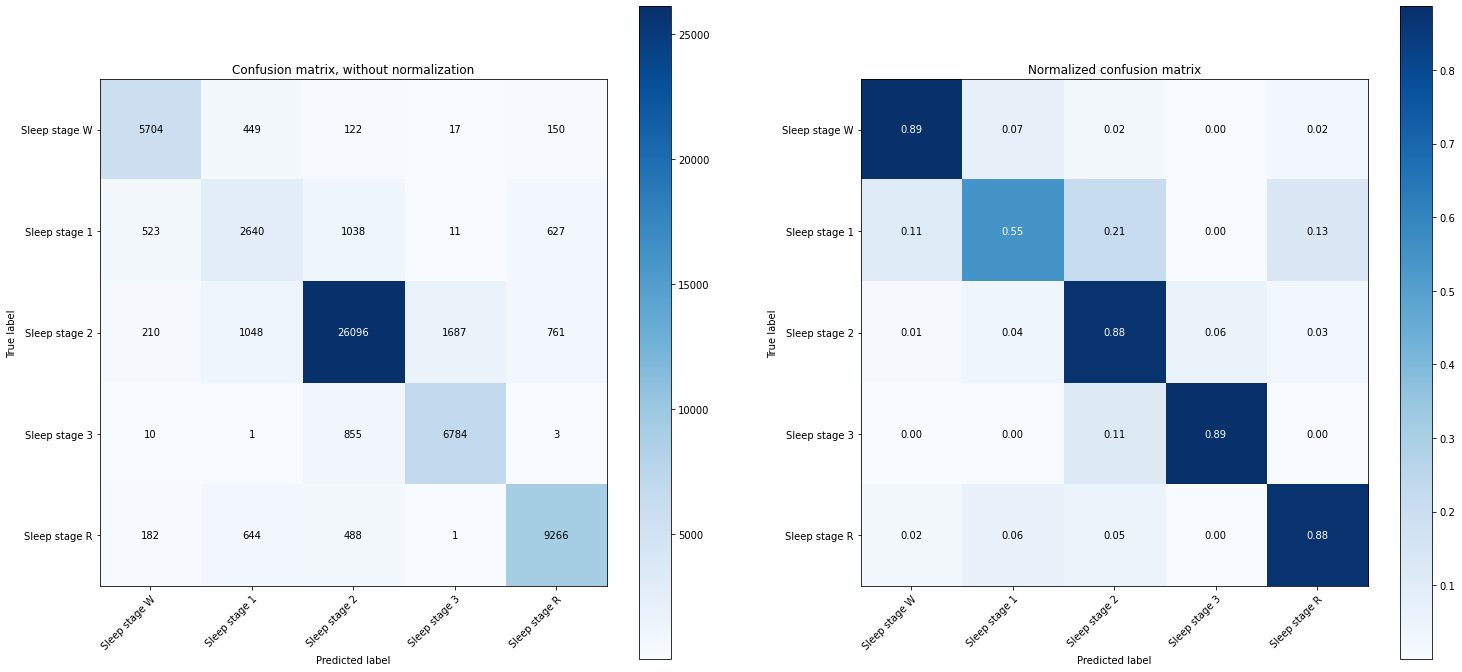

In [80]:
classes = [
    'Sleep stage W',
    'Sleep stage 1',
    'Sleep stage 2',
    'Sleep stage 3',
    'Sleep stage R'
]

plt.figure(figsize=(25,12))
ax = plt.subplot(1,2,1)
plot_confusion_matrix(y_pred=preds, y_true=y_trues, classes=classes, normalize=False, ax=ax)
ax = plt.subplot(1,2,2)
plot_confusion_matrix(y_pred=preds, y_true=y_trues, classes=classes, normalize=True, ax=ax)

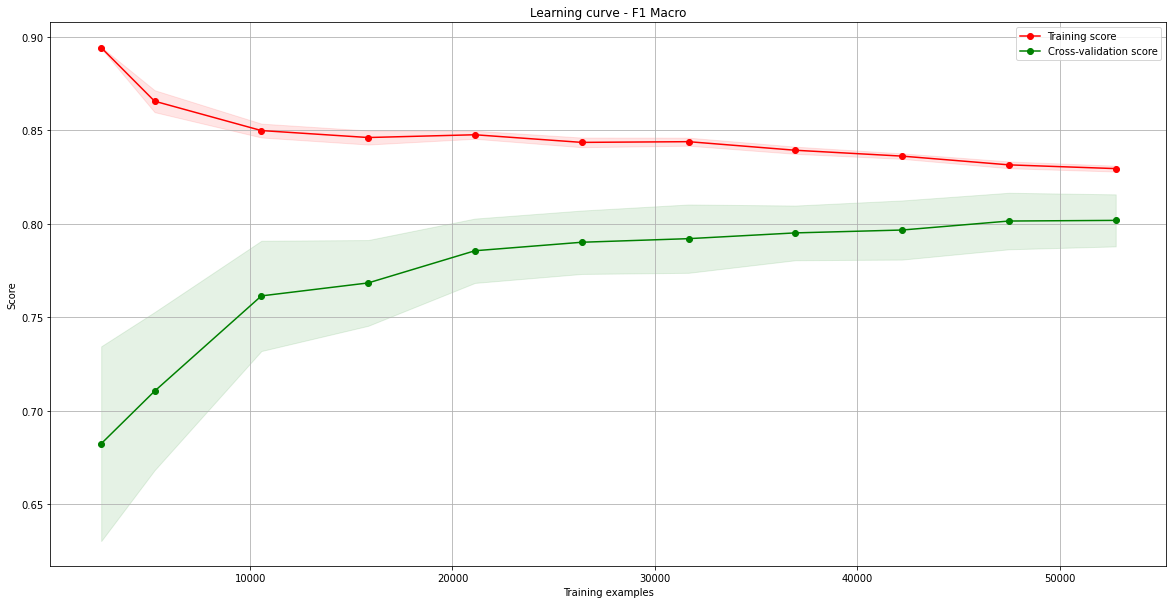

In [81]:
cv = gkfold.split(df_feats, df_feats["label"], groups=df_feats.psg_file)
_ = plot_learning_curve(
    pipe,
    title="Learning curve - F1 Macro",
    X=df_feats[feat_cols],
    y=df_feats["label"],
    cv=cv,
    scoring="f1_macro",
    n_jobs=20,
    train_sizes=[0.05] + list(np.linspace(0.1,1,10))
)


### Grouped X-fold results for all the data

In [82]:
# Total of 10 folds
gkfold = StratifiedGroupKFold(n_splits=31)
cv = gkfold.split(df_feats, df_feats["label"], groups=df_feats.psg_file)

res = cross_validate(
    pipe,
    df_feats[feat_cols],
    df_feats["label"],
    scoring=["f1_macro", "balanced_accuracy", "accuracy", "neg_log_loss"],
    cv=cv,
    n_jobs=25,
    return_train_score=True,
    return_estimator=True,
)

In [83]:
print("31-FOLD: TRAIN")
print("  MACRO F1:          ", round(np.mean(res["train_f1_macro"]), 4))
print("  Balanced accuracy: ", round(np.mean(res["train_balanced_accuracy"]), 4))
print("  Accuracy:          ", round(np.mean(res["train_accuracy"]), 4))
print("  Log loss:          ", round(np.mean(-1 * res["train_neg_log_loss"]), 4))

31-FOLD: TRAIN
  MACRO F1:           0.8278
  Balanced accuracy:  0.8375
  Accuracy:           0.8699
  Log loss:           0.5191


In [84]:
print("31-FOLD: TEST")
print("  MACRO F1:          ", round(np.mean(res["test_f1_macro"]), 4))
print("  Balanced accuracy: ", round(np.mean(res["test_balanced_accuracy"]), 4))
print("  Accuracy:          ", round(np.mean(res["test_accuracy"]), 4))
print("  Log loss:          ", round(np.mean(-1 * res["test_neg_log_loss"]), 4))


31-FOLD: TEST
  MACRO F1:           0.7984
  Balanced accuracy:  0.8102
  Accuracy:           0.852
  Log loss:           0.6439


In [85]:
preds = []
preds_proba = []
y_trues = []
selected_feats = []
cv = gkfold.split(df_feats, df_feats["label"], groups=df_feats.patient_id)
for fold_ix, (train_idx, test_idx) in enumerate(cv):
    X_train = df_feats[feat_cols].iloc[train_idx]
    y_train = df_feats["label"].iloc[train_idx]
    X_test = df_feats[feat_cols].iloc[test_idx]
    y_test = df_feats["label"].iloc[test_idx]
    
    estimator = res["estimator"][fold_ix]
    preds += [estimator.predict(X_test)]
    preds_proba += [estimator.predict_proba(X_test)]
    y_trues += [y_test]
    selected_feats += [np.array(feat_cols)[estimator["selector"].get_support()]]

preds = np.hstack(preds)
y_trues = np.hstack(y_trues)
preds_proba = np.vstack(preds_proba)

917 features in total
fold 0  911 features selected
fold 1  910 features selected
fold 2  908 features selected
fold 3  909 features selected
fold 4  909 features selected
fold 5  909 features selected
fold 6  907 features selected
fold 7  911 features selected
fold 8  909 features selected
fold 9  910 features selected
fold 10  909 features selected
fold 11  909 features selected
fold 12  909 features selected
fold 13  908 features selected
fold 14  910 features selected
fold 15  907 features selected
fold 16  908 features selected
fold 17  909 features selected
fold 18  909 features selected
fold 19  911 features selected
fold 20  907 features selected
fold 21  910 features selected
fold 22  909 features selected
fold 23  910 features selected
fold 24  909 features selected
fold 25  909 features selected
fold 26  909 features selected
fold 27  909 features selected
fold 28  911 features selected
fold 29  907 features selected
fold 30  911 features selected

904 features in intersecti

Text(0.5, 0, 'times selected')

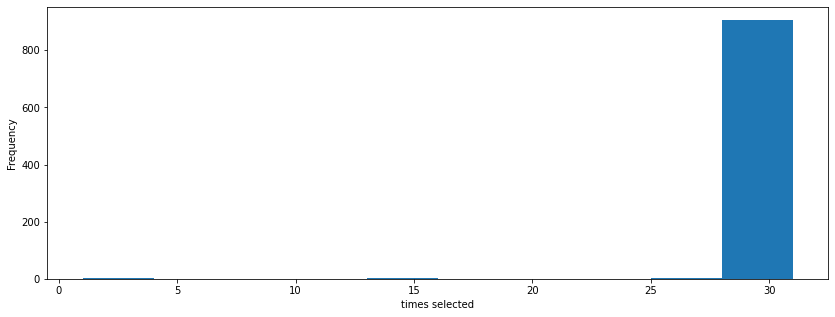

In [86]:
print(f"{len(feat_cols)} features in total")

selection_df = pd.DataFrame(data=set.union(*map(set, selected_feats)), columns=["feature"])
selection_df["times_selected"] = 0

for fold, feats in enumerate(selected_feats):
    print(f"fold {fold}  {len(feats)} features selected")
    selection_df.loc[selection_df.feature.isin(feats), "times_selected"] += 1

print()
print(f"{len(set.intersection(*map(set, selected_feats)))} features in intersection")
print(f"{len(set.union(*map(set, selected_feats)))} features in union")

ax = selection_df["times_selected"].plot(kind="hist", bins=10, figsize=(14,5))
plt.xlabel("times selected")

In [87]:
print("F1:", f1_score(preds, y_trues, average="macro"))
print("ACC:", accuracy_score(preds, y_trues))
print("KAPPA:", cohen_kappa_score(preds, y_trues))
print("LOG LOSS:", log_loss(y_trues, preds_proba))

F1: 0.8048063872155273
ACC: 0.8520323010266871
KAPPA: 0.7849231904934161
LOG LOSS: 0.6440342410128926


In [88]:
print(classification_report(np.hstack(preds), np.hstack(y_trues)))

               precision    recall  f1-score   support

Sleep stage 1       0.55      0.55      0.55      4759
Sleep stage 2       0.88      0.91      0.89     28601
Sleep stage 3       0.88      0.80      0.84      8425
Sleep stage R       0.88      0.86      0.87     10883
Sleep stage W       0.89      0.86      0.87      6649

     accuracy                           0.85     59317
    macro avg       0.81      0.80      0.80     59317
 weighted avg       0.85      0.85      0.85     59317



<AxesSubplot:title={'center':'Normalized confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

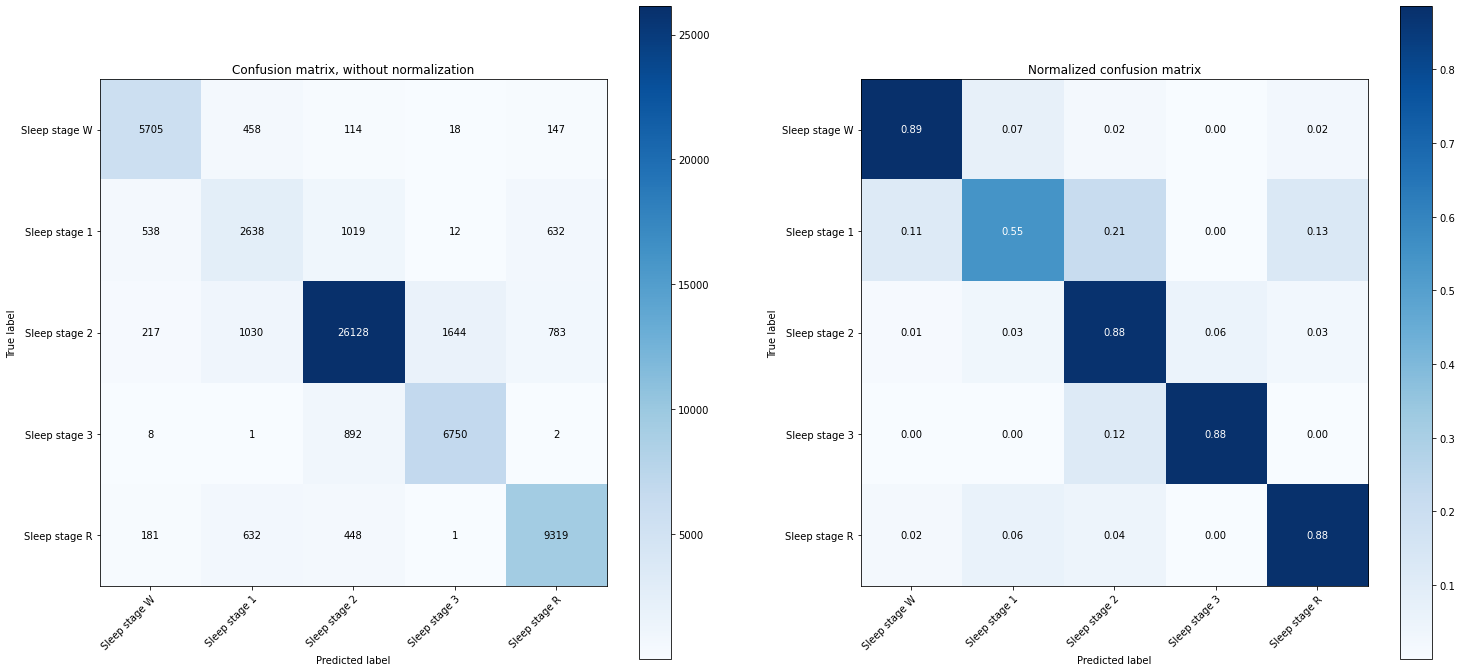

In [89]:
classes = [
    'Sleep stage W',
    'Sleep stage 1',
    'Sleep stage 2',
    'Sleep stage 3',
    'Sleep stage R'
]

plt.figure(figsize=(25,12))
ax = plt.subplot(1,2,1)
plot_confusion_matrix(y_pred=preds, y_true=y_trues, classes=classes, normalize=False, ax=ax)
ax = plt.subplot(1,2,2)
plot_confusion_matrix(y_pred=preds, y_true=y_trues, classes=classes, normalize=True, ax=ax)

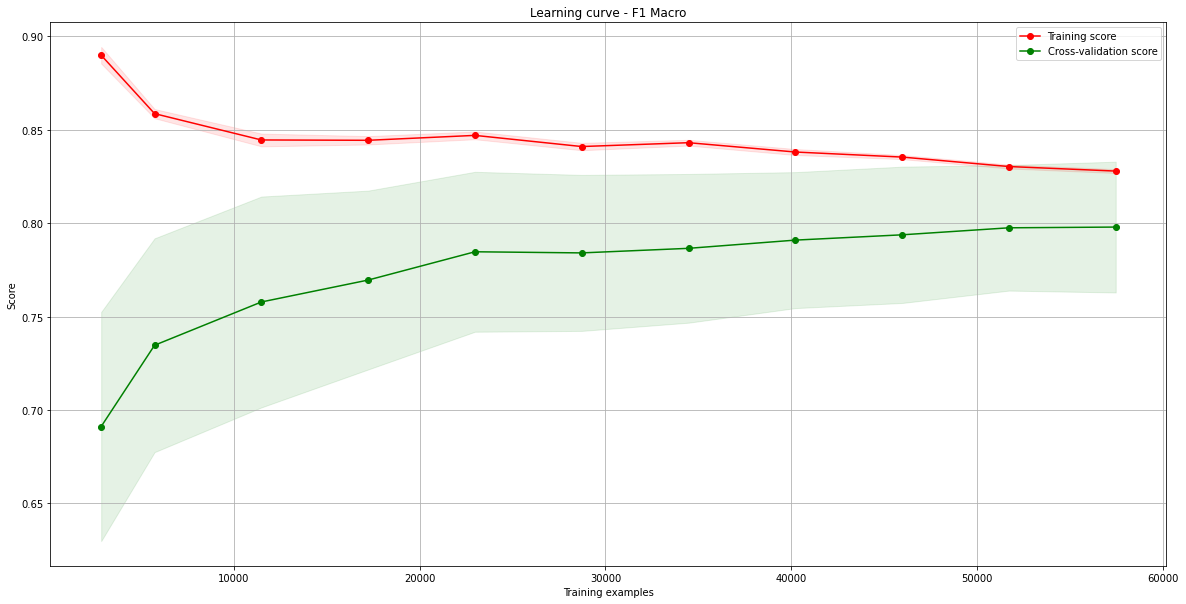

In [90]:
cv = gkfold.split(df_feats, df_feats["label"], groups=df_feats.psg_file)
_ = plot_learning_curve(
    pipe,
    title="Learning curve - F1 Macro",
    X=df_feats[feat_cols],
    y=df_feats["label"],
    cv=cv,
    scoring="f1_macro",
    n_jobs=20,
    train_sizes=[0.05] + list(np.linspace(0.1,1,10))
)